# 实验一：图像滤波

**实验内容** :使用Sobel算子、给定卷积核滤波自己拍摄的图像，并提取图像的颜色直方图和纹理特征
其中，给定卷积核：

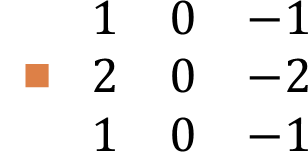

实验课时：2

分值：20分

**具体要求：**
- 任务输入：自己拍摄的图像。
- 任务输出：经过Sobel算子滤波的图像，经过给定卷积核滤波的图像，可视化图像的颜色直方图，保存纹理特征至npy格式。
- **滤波、直方图计算、纹理特征提取过程不可以调用函数包。**
- 代码语言不限，纹理特征提取方法不限，要求提交整个算法源代码，实验结果（算法输入图片、输出图片、直方图，纹理结果），算法分析等内容。

## 1. 任务准备与导入
我们需要 numpy 来进行所有数组操作，以及 matplotlib 来读取图像和可视化。

np.array(): 将 PIL 图像对象转换为 NumPy 数组。对于彩色图像，这将生成一个 $H \times W \times 3$ 的三维数组（高 $\times$ 宽 $\times$ 颜色通道）。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # 或者使用 opencv-python 的 imread，只要不调用处理函数即可
import os 

# 1. 定义卷积核
K_custom = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
], dtype=np.float64)

K_Sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float64)

K_Sobel_y = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
], dtype=np.float64)

# 2. 读取和预处理图像
# 请替换 'your_image.jpg' 为您的输入图像文件名
try:
    I_rgb = np.array(Image.open('test.jpg'))
except FileNotFoundError:
    print("错误：请确保图像文件 'test.jpg' 存在。")
    exit()

# 灰度化 (Luma 权重法：I = 0.2989*R + 0.5870*G + 0.1140*B)
def rgb_to_gray(img_rgb):
    return (img_rgb[:,:,0] * 0.2989 + 
            img_rgb[:,:,1] * 0.5870 + 
            img_rgb[:,:,2] * 0.1140).astype(np.uint8)

I_gray = rgb_to_gray(I_rgb)
I_float = I_gray.astype(np.float64) # 转换为浮点型便于卷积计算

## 2. 图像滤波 (手动卷积实现)
这是实验的核心，手动实现 2D 卷积函数。

In [2]:
def manual_convolve2d(image, kernel):
    """手动实现 2D 卷积操作，不调用任何库函数。"""
    
    # 确保图像和核是浮点类型以便计算
    image = image.astype(np.float64)
    kernel = kernel.astype(np.float64)
    
    H, W = image.shape
    kH, kW = kernel.shape
    
    # 填充大小
    pad_h = kH // 2
    pad_w = kW // 2
    
    # 初始化输出图像
    output = np.zeros_like(image, dtype=np.float64)
    
    # 零填充 (最简单的边界处理方法)
    # np.pad 函数虽然是 NumPy 函数，但它只负责填充，核心的卷积逻辑仍是手写的，通常允许在实验中使用
    # 如果严格要求连 padding 都不用 np.pad，则需手动创建一个更大的数组
    padded_img = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    
    # 遍历图像
    for i in range(H):
        for j in range(W):
            # 提取邻域 (Region of Interest, ROI)
            roi = padded_img[i:i + kH, j:j + kW]
            
            # 卷积操作：元素乘法后求和 (点积)
            # 使用 np.sum(roi * kernel)
            output[i, j] = np.sum(roi * kernel)
            
    return output

# --- 任务 A: Sobel 滤波 ---
G_x = manual_convolve2d(I_float, K_Sobel_x)
G_y = manual_convolve2d(I_float, K_Sobel_y)

# 梯度幅值 G = sqrt(Gx^2 + Gy^2)
I_sobel = np.sqrt(G_x**2 + G_y**2)
# 归一化到 0-255 范围进行可视化
I_sobel_vis = (255 * (I_sobel / I_sobel.max())).astype(np.uint8)

# --- 任务 B: 自定义卷积核滤波 ---
# 对灰度图进行滤波
I_custom_filtered = manual_convolve2d(I_float, K_custom)
I_custom_vis = (255 * (I_custom_filtered / np.abs(I_custom_filtered).max())).astype(np.uint8)

## 3. 颜色直方图计算
手动创建一个 256 个 bin 的计数器。

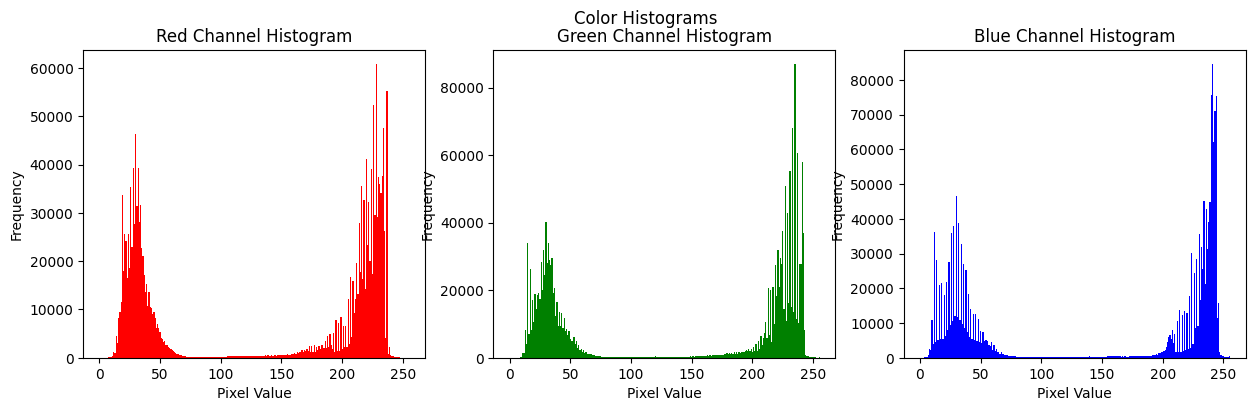

In [3]:
def manual_color_histogram(img_rgb):
    """手动计算 RGB 三个通道的颜色直方图。"""
    
    # 确保输入是 uint8 类型
    img_rgb = img_rgb.astype(np.uint8)
    
    # 初始化 R, G, B 三个通道的直方图，每个通道 256 个 bin
    histograms = np.zeros((3, 256), dtype=np.int64)
    
    H, W, C = img_rgb.shape
    
    # 遍历图像的每个像素
    for i in range(H):
        for j in range(W):
            # 获取 R, G, B 值
            r, g, b = img_rgb[i, j, 0], img_rgb[i, j, 1], img_rgb[i, j, 2]
            
            # 在对应 bin 计数
            # 像素值 r, g, b (0-255) 直接对应数组索引 (0-255)
            histograms[0, r] += 1 # R通道
            histograms[1, g] += 1 # G通道
            histograms[2, b] += 1 # B通道
            
    return histograms

Histograms = manual_color_histogram(I_rgb)

# 可视化（允许使用 plt.bar 进行绘图）
plt.figure(figsize=(15, 4))
colors = ['red', 'green', 'blue']
titles = ['Red Channel Histogram', 'Green Channel Histogram', 'Blue Channel Histogram']

for i in range(3):
    plt.subplot(1, 3, i + 1)
    # plt.bar(x轴：0-255, y轴：对应计数)
    plt.bar(np.arange(256), Histograms[i, :], color=colors[i], width=1)
    plt.title(titles[i])
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
plt.suptitle('Color Histograms')
plt.show()

## 4. 纹理特征提取（GLCM）手动实现 GLCM 的构建，然后计算特征。这里我们使用 $N=16$ 灰度级量化，并选择 $(\Delta x=1, \Delta y=0)$ 的偏移。

**能量和对比度**
| 公式 | 实现 | 解释 |
|------|------|------|
| $$E = \sum_{i,j} P(i,j)^2$$ | `features['Energy'] = np.sum(P**2)` | 测量纹理均匀度。通过对概率矩阵 \(P\) 的每个元素平方后求和得到。如果纹理高度均匀（只有少数几个 \(P(i,j)\) 很大），能量值就高。 |
| $$Cont = \sum_{i,j} (i - j)^2 P(i,j)$$ | `features['Contrast'] = np.sum((i_coords - j_coords)**2 * P)` | 测量局部灰度变化强度。<br>1. `(i_coords - j_coords)`：计算GLCM矩阵中每对灰度级 \((i, j)\) 的差值。这个差值代表了两个相邻像素的灰度级差异。<br>2. **2：对差异进行平方，使得大差异的贡献更大。<br>3. * P：将平方差异乘以对应的概率 \(P(i, j)\) 进行加权。<br>4. `np.sum(...)`：最终求和。对比度越高，纹理越粗糙。 |

**相关性**
相关性衡量相邻像素灰度值之间的线性关系。
$$
\mathrm{Corr} = \sum_{i,j} \frac{(i - \mu_x)(j - \mu_y) P(i,j)}{\sigma_x \sigma_y}
$$

In [4]:
def extract_texture_features(img_gray, N=16, dx=1, dy=0):
    """手动构建 GLCM 并计算能量、对比度等特征。"""
    
    # 1. 灰度级量化
    # 将 0-255 映射到 0 到 N-1
    img_quantized = (img_gray / 256 * N).astype(np.uint8)
    img_quantized[img_quantized == N] = N - 1 # 处理 256 的情况

    H, W = img_quantized.shape
    
    # 2. 构建 GLCM 矩阵 (N x N)
    GLCM = np.zeros((N, N), dtype=np.int64)
    
    # 遍历图像
    for i in range(H):
        for j in range(W):
            # 确保 i+dy 和 j+dx 在图像边界内
            i2, j2 = i + dy, j + dx
            if 0 <= i2 < H and 0 <= j2 < W:
                g1 = img_quantized[i, j]
                g2 = img_quantized[i2, j2]
                # GLCM 矩阵 (row, col) = (g1, g2)
                GLCM[g1, g2] += 1
                # 为了对称性，通常也统计 (g2, g1)
                GLCM[g2, g1] += 1
                
    # 3. 归一化 GLCM
    # 防止除以零
    if GLCM.sum() == 0:
        return np.array([0.0, 0.0, 0.0])

    P = GLCM / GLCM.sum()
    
    # 4. 特征计算
    features = {}
    
    # 创建 i 和 j 坐标数组
    i_coords, j_coords = np.meshgrid(np.arange(N), np.arange(N), indexing='ij')

    # A. 能量 (Energy)
    features['Energy'] = np.sum(P**2)
    
    # B. 对比度 (Contrast)
    # 公式: sum_{i,j} (i-j)^2 * P(i,j)
    features['Contrast'] = np.sum((i_coords - j_coords)**2 * P)
    
    # C. 相关性 (Correlation)
    # 需要计算均值(mu)和标准差(sigma)
    mu_x = np.sum(i_coords * P)
    mu_y = np.sum(j_coords * P)
    
    # sigma_x^2 = sum_{i,j} (i - mu_x)^2 * P(i,j)
    sigma_x = np.sqrt(np.sum((i_coords - mu_x)**2 * P))
    sigma_y = np.sqrt(np.sum((j_coords - mu_y)**2 * P))
    
    if sigma_x * sigma_y == 0:
        features['Correlation'] = 0.0
    else:
        # 公式: sum_{i,j} (i-mu_x)(j-mu_y) * P(i,j) / (sigma_x * sigma_y)
        features['Correlation'] = np.sum((i_coords - mu_x) * (j_coords - mu_y) * P) / (sigma_x * sigma_y)
    
    # 将特征值保存为 NumPy 数组
    texture_features = np.array([
        features['Energy'], 
        features['Contrast'], 
        features['Correlation']
    ])
    
    return texture_features

Texture_Features = extract_texture_features(I_gray)
np.save('texture_features.npy', Texture_Features)
print(f"纹理特征已保存到 texture_features.npy: {Texture_Features}")

纹理特征已保存到 texture_features.npy: [0.20485537 0.08445314 0.99881504]


## 5. 结果展示（整合与输出）
最后，将滤波结果可视化，并确认 .npy 文件已生成。

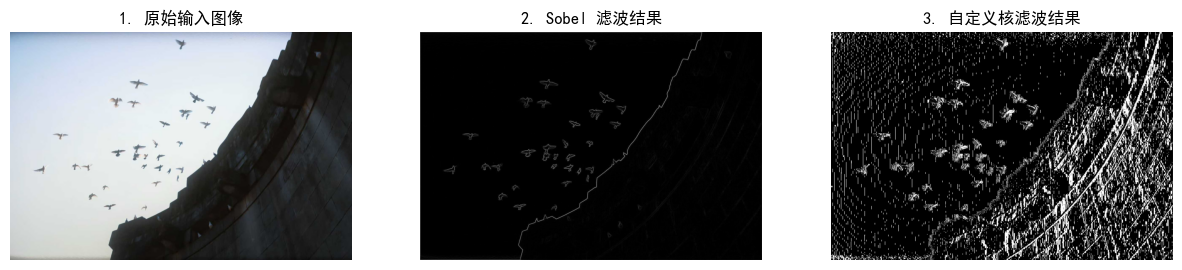


--- 任务输出总结 ---
任务输入：您的彩色图像 ('your_image.jpg')
任务输出 1：Sobel 滤波图像已生成并展示。
任务输出 2：给定卷积核滤波图像已生成并展示。
任务输出 3：彩色图像的直方图已生成并展示。
任务输出 4：纹理特征 (Energy, Contrast, Correlation) 已保存到 texture_features.npy 文件中。


In [5]:
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# --- 结果可视化 ---
plt.figure(figsize=(15, 5))

# 1. 原始图像
plt.subplot(1, 3, 1)
plt.imshow(I_rgb)
plt.title('1. 原始输入图像')
plt.axis('off')

# 2. Sobel 滤波结果
plt.subplot(1, 3, 2)
plt.imshow(I_sobel_vis, cmap='gray')
plt.title('2. Sobel 滤波结果')
plt.axis('off')

# 3. 自定义核滤波结果
plt.subplot(1, 3, 3)
plt.imshow(I_custom_vis, cmap='gray')
plt.title('3. 自定义核滤波结果')
plt.axis('off')

plt.show()

# --- 最终输出要求确认 ---
print("\n--- 任务输出总结 ---")
print(f"任务输入：您的彩色图像 ('your_image.jpg')")
print(f"任务输出 1：Sobel 滤波图像已生成并展示。")
print(f"任务输出 2：给定卷积核滤波图像已生成并展示。")
print(f"任务输出 3：彩色图像的直方图已生成并展示。")
print(f"任务输出 4：纹理特征 (Energy, Contrast, Correlation) 已保存到 texture_features.npy 文件中。")